# Exponential Mechanism Quantiles

This section explains the algorithm used to release a differentially private quantile using the exponential mechanism in the OpenDP Library.

Our data will just be 1000 samples from the gaussian distribution.

In [8]:
%pip install opendp
%pip install 'opendp[polars]'

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [9]:
import numpy as np
data = np.random.normal(scale=10, size=1000)

The following algorithm approximately chooses the candidate nearest to the alpha-quantile.

In [10]:
import opendp.prelude as dp
dp.enable_features("contrib", "honest-but-curious")

space = dp.vector_domain(dp.atom_domain(T=float, nan=False)), dp.symmetric_distance()
candidates = np.linspace(-50, 50, 101).tolist()

m_median = space >> dp.m.then_private_quantile(
    candidates=candidates,
    alpha=0.7,
    scale=1.0
)
print(m_median(data))

m_median.map(d_in=1)

6.0


0.7000000000000001

The algorithm breaks down into three smaller steps:

In [11]:
m_median = (
    space
    # 1. transformation: compute a score for each candidate
    >> dp.t.then_quantile_score_candidates(candidates, alpha=0.7)
    # 2. measurement: privately select the index of the best score
    >> dp.m.then_report_noisy_max_gumbel(scale=1.0, optimize="min")
    # 3. postprocessor: return the candidate with the selected index
    >> (lambda i: candidates[i])
)

m_median(data)

6.0

## 1. Score Each Candidate

The `quantile_score_candidates` transformation assigns scores to each candidate by the number of records between the candidate and true quantile.
The scoring is similar to golf, where scores closer to zero are considered better.

In [12]:
candidates = np.linspace(-50, 50, 101).tolist()

t_median_scores = dp.t.make_quantile_score_candidates(
    dp.vector_domain(dp.atom_domain(T=float, nan=False)), 
    dp.symmetric_distance(), 
    candidates, 
    alpha=0.7)

# plot the scores
scores = t_median_scores(data)

$\textrm{score}(x, c, \alpha_{num}, \alpha_{den}) = -|\alpha_{den} \cdot \#(x < c) - \alpha_{num} \cdot (|x| - \#(x = c))|$

7000
Sensibilité : 7000


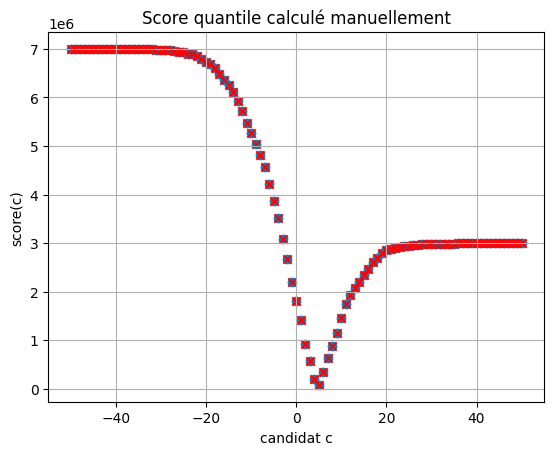

In [61]:
import numpy as np

# Supposons que `data` est un tableau 1D (liste ou array) des valeurs observées
alpha = 0.7
candidates = np.linspace(-50, 50, 101)

t_median_scores = dp.t.make_quantile_score_candidates(
    dp.vector_domain(dp.atom_domain(T=float, nan=False)), 
    dp.symmetric_distance(), 
    candidates, 
    alpha=alpha)

# plot the scores
scores = t_median_scores(data)
sensibilite= t_median_scores.map(d_in=1)
print(sensibilite)

def manual_quantile_score(data, candidates, alpha_num, alpha_denum):
    scores = []
    for c in candidates:
        n_less = np.sum(data < c)
        n_equal = np.sum(data == c)
        score = alpha_denum * n_less - alpha_num * (len(data) - n_equal)
        scores.append(abs(score))
    print("Sensibilité :", max(alpha_num, alpha_denum - alpha_num))
    return np.array(scores)

scores_m = manual_quantile_score(data, candidates, alpha_num = 7000, alpha_denum=10000)


# Pour alpha = 0, alpha_num = 0, alpha_denum = 1
# Pour alpha = 0.25 , alpha_num = 1, alpha_denum = 4
# Pour alpha = 0.5, alpha_num = 1, alpha_denum = 2
# Pour alpha = 0.75 , alpha_num = 3, alpha_denum = 4
# Pour alpha = 1, alpha_num = 1, alpha_denum = 1

# Pour le reste, alpha_num = floor(alpha * 10000), alpha_denum = 10000

# Tracé
import matplotlib.pyplot as plt

plt.scatter(candidates, scores_m, marker='o')
plt.scatter(candidates, scores, color = "red", marker='x')
plt.title("Score quantile calculé manuellement")
plt.xlabel("candidat c")
plt.ylabel("score(c)")
plt.grid(True)
plt.show()


In [14]:
space = dp.vector_domain(dp.atom_domain(T=float, nan=False)), dp.symmetric_distance()
candidates = np.linspace(-50, 50, 101).tolist()


scale = dp.binary_search_param(
            lambda s: space
        # 1. transformation: compute a score for each candidate
        >> dp.t.then_quantile_score_candidates(candidates, alpha=alpha)
        # 2. measurement: privately select the index of the best score
        >> dp.m.then_report_noisy_max_gumbel(scale=s, optimize="min"),
            d_in=1, d_out=1)
print(scale)

14000.0


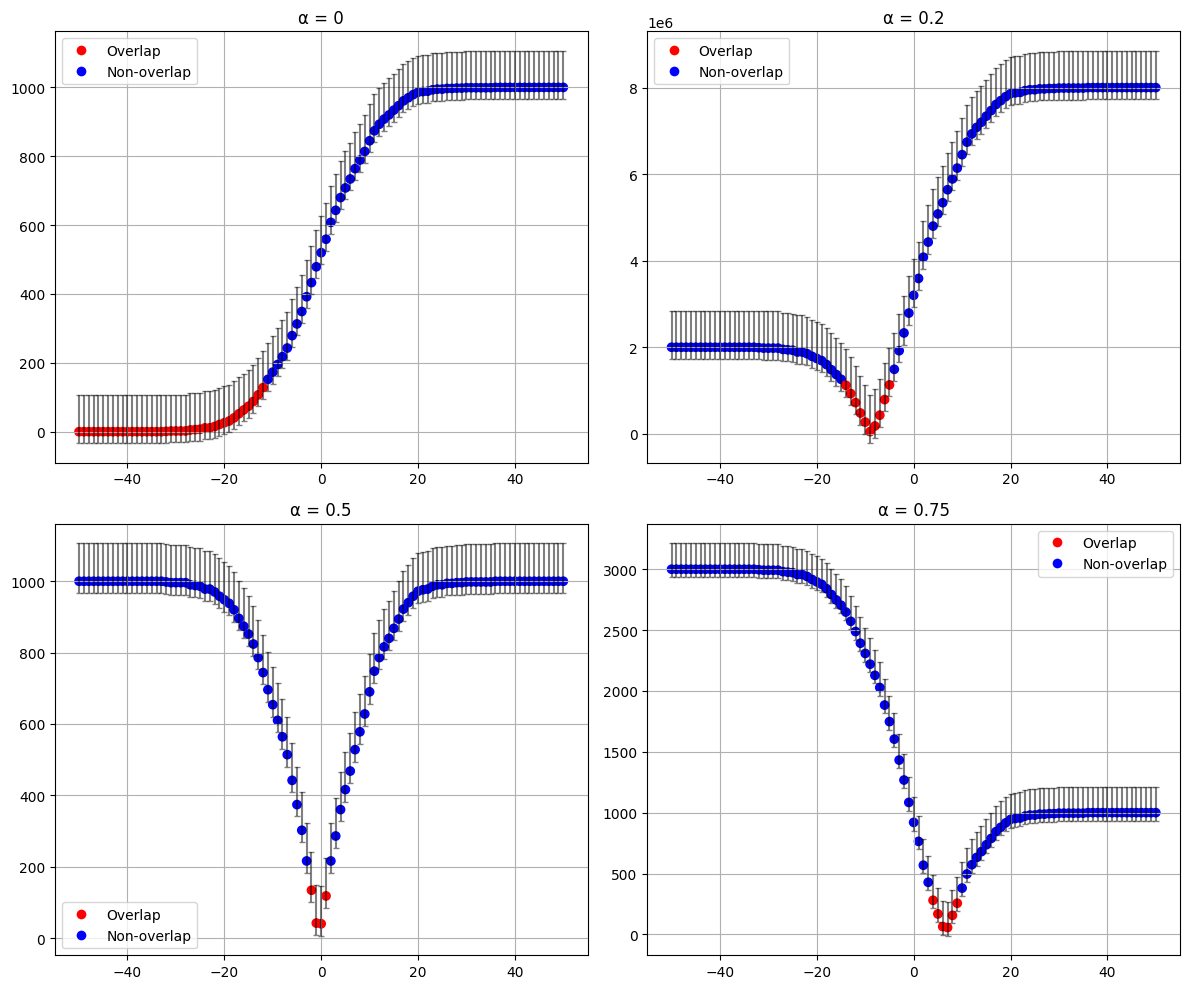

In [119]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gumbel_r

np.random.seed(123)

data = np.random.normal(scale=10, size=1000)

list_alpha = [0, 0.2, 0.5, 0.75]
list_sensibilite = [1, 8000, 1, 2]
candidates = np.linspace(-50, 50, 101).tolist()
epsilon = 0.1

fig, axs = plt.subplots(2, 2, figsize=(12, 10))

for i, ax in enumerate(axs.flat):
    # Score pour alpha courant
    t_median_scores = dp.t.make_quantile_score_candidates(
        dp.vector_domain(dp.atom_domain(T=float, nan=False)), 
        dp.symmetric_distance(), 
        candidates, 
        alpha=list_alpha[i])

    scores = t_median_scores(data)
    low_q, high_q = gumbel_r.ppf([0.005, 0.995], loc=0, scale=2 * list_sensibilite[i] / epsilon)

    lower = scores + low_q
    upper = scores + high_q

    # Trouver l’indice du score minimal
    min_idx = np.argmin(scores)
    min_lower = lower[min_idx]
    min_upper = upper[min_idx]

    # Déterminer la couleur de chaque point
    colors = []
    for l, u in zip(lower, upper):
        if not (u < min_lower or l > min_upper):
            colors.append('red')  # intervalle touche celui du minimum
        else:
            colors.append('blue')

    # Tracé avec couleurs personnalisées
    ax.scatter(candidates, scores, c=colors, label='Scores')
    ax.errorbar(candidates, scores, yerr=[scores - lower, upper - scores],
                fmt='none', capsize=2, color='black', alpha = 0.5)
    
    ax.set_title(f"α = {list_alpha[i]}")
    ax.grid(True)
    ax.legend(handles=[
        plt.Line2D([0], [0], marker='o', color='w', label='Overlap', markerfacecolor='red', markersize=8),
        plt.Line2D([0], [0], marker='o', color='w', label='Non-overlap', markerfacecolor='blue', markersize=8)
    ])

plt.tight_layout()
plt.show()


Sensibilité : 7500


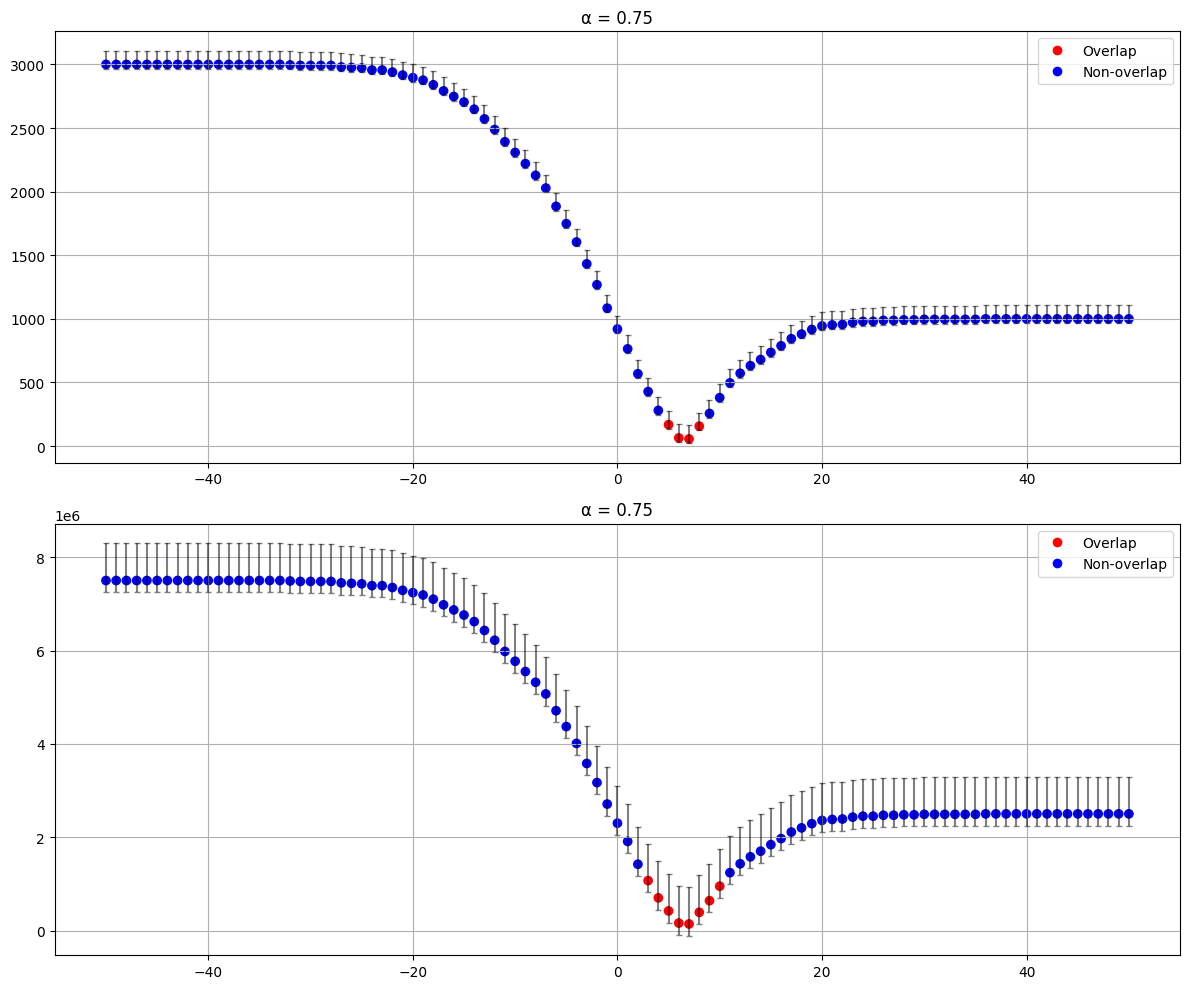

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gumbel_l

np.random.seed(123)

data = np.random.normal(scale=10, size=1000)
alpha = 0.75
list_sensibilite = [1, 7500]
candidates = np.linspace(-50, 50, 101).tolist()
epsilon = 0.1

fig, axs = plt.subplots(2, figsize=(12, 10))

for i, ax in enumerate(axs.flat):

    if i == 0:
        # Score pour alpha courant
        t_median_scores = dp.t.make_quantile_score_candidates(
            dp.vector_domain(dp.atom_domain(T=float, nan=False)), 
            dp.symmetric_distance(), 
            candidates, 
            alpha=alpha)

        scores = t_median_scores(data)

    else :
        scores = manual_quantile_score(data, candidates, alpha_num = 7500, alpha_denum=10000)
        
    low_q, high_q = gumbel_r.ppf([0.005, 0.995], loc=0, scale=2 * list_sensibilite[i] / epsilon)

    lower = scores + low_q
    upper = scores + high_q

    # Trouver l’indice du score minimal
    min_idx = np.argmin(scores)
    min_lower = lower[min_idx]
    min_upper = upper[min_idx]

    # Déterminer la couleur de chaque point
    colors = []
    for l, u in zip(lower, upper):
        if not (u < min_lower or l > min_upper):
            colors.append('red')  # intervalle touche celui du minimum
        else:
            colors.append('blue')

    # Tracé avec couleurs personnalisées
    ax.scatter(candidates, scores, c=colors, label='Scores')
    ax.errorbar(candidates, scores, yerr=[scores - lower, upper - scores],
                fmt='none', capsize=2, color='black', alpha = 0.5)
    
    ax.set_title(f"α = {alpha}")
    ax.grid(True)
    ax.legend(handles=[
        plt.Line2D([0], [0], marker='o', color='w', label='Overlap', markerfacecolor='red', markersize=8),
        plt.Line2D([0], [0], marker='o', color='w', label='Non-overlap', markerfacecolor='blue', markersize=8)
    ])

plt.tight_layout()
plt.show()

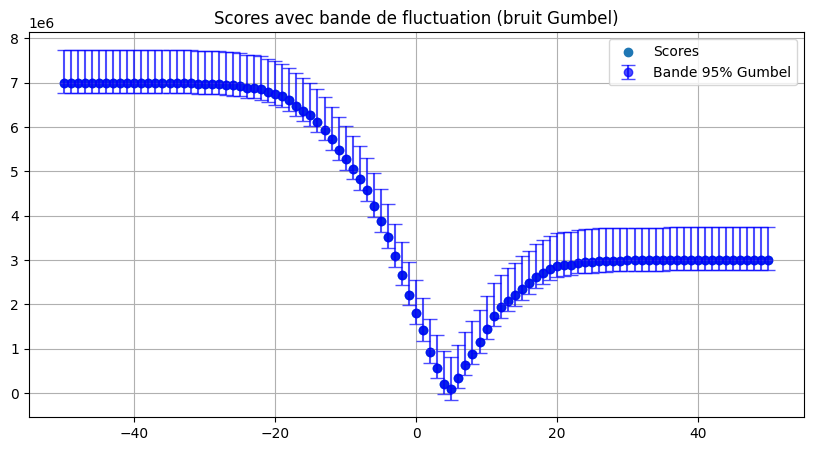

In [57]:
t_median_scores = dp.t.make_quantile_score_candidates(
    dp.vector_domain(dp.atom_domain(T=float, nan=False)), 
    dp.symmetric_distance(), 
    candidates, 
    alpha=0.7)

# Scores médians "non bruités"
scores = t_median_scores(data)
sensibilite = 7000
epsilon = 0.1

# Bornes de l'IC à 95 % du bruit Gumbel
low_q, high_q = gumbel_r.ppf([0.005, 0.995], loc=0, scale=2*sensibilite/epsilon)

# Calcul des bandes pour chaque score
lower = scores + low_q
upper = scores + high_q

# Tracé
plt.figure(figsize=(10, 5))
plt.scatter(candidates, scores, label='Scores')
plt.errorbar(candidates, scores, yerr=[scores - lower, upper - scores],
             fmt='o', capsize=5, color='blue', alpha=0.7, label='Bande 95% Gumbel')
plt.title("Scores avec bande de fluctuation (bruit Gumbel)")
plt.legend()
plt.grid(True)
plt.show()

Since the data was sampled with a mean of 50, candidates nearer to 50 get better scores.
The scores increase quickly away from 50 because the data is concentrated at 50.

The scoring transformation is considered stable because each score can change by no more than one, when one record is added or removed.
That is, when one new record is added, the number of records between a candidate and the true quantile can change by at most one.

In [128]:
t_median_scores.map(d_in=1)

9000

The sensitivity of the score vector is based on the $L_\infty$ sensitivity, or the max change of any one score.

In [114]:
import opendp.prelude as dp
dp.enable_features("contrib", "honest-but-curious")

np.random.seed(123)

data = np.random.normal(scale=10, size=1000)

space = dp.vector_domain(dp.atom_domain(T=float, nan=False)), dp.symmetric_distance()
candidates = np.linspace(-50, 50, 101).tolist()

scale = dp.binary_search_param(
            lambda s: space
        # 1. transformation: compute a score for each candidate
        >> dp.t.then_quantile_score_candidates(candidates, alpha=0.75)
        # 2. measurement: privately select the index of the best score
        >> dp.m.then_report_noisy_max_gumbel(scale=s, optimize="min")
        >> (lambda i: candidates[i]),
            d_in=1, d_out=0.1)
print(scale)

quantile = space >> dp.m.then_private_quantile(
        candidates=candidates,
        alpha=0.75,
        scale=scale
    )

list_values = []

for i in range(500):
    list_values.append(quantile(data))

print(len(set(list_values)))

60.0
59


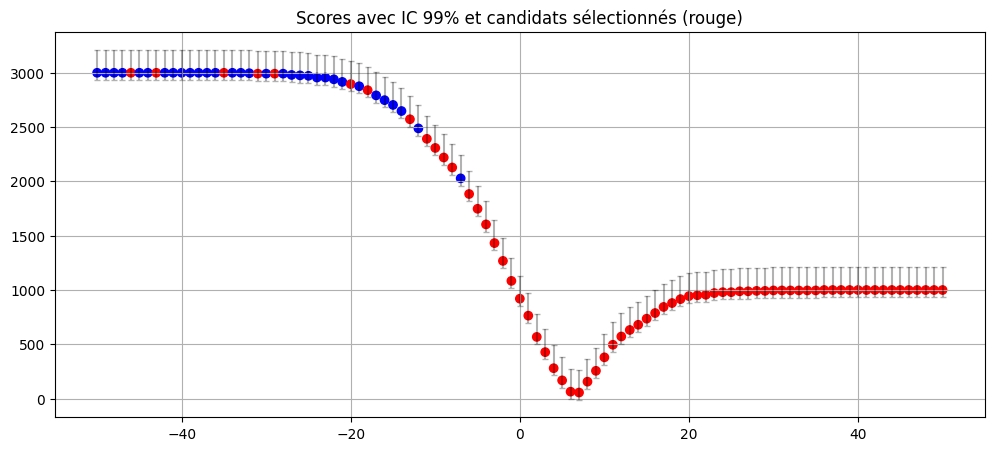

69 candidats sélectionnés au moins une fois


In [120]:
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gumbel_r
import opendp.prelude as dp
dp.enable_features("contrib", "honest-but-curious")

np.random.seed(123)

data = np.random.normal(scale=10, size=1000)
candidates = np.linspace(-50, 50, 101).tolist()
alpha = 0.75
epsilon = 0.1
sensibilite = 2

# Score non bruité
t_median_scores = dp.t.make_quantile_score_candidates(
    dp.vector_domain(dp.atom_domain(T=float, nan=False)), 
    dp.symmetric_distance(), 
    candidates, 
    alpha=alpha)

scores = t_median_scores(data)

# IC à 99 %
low_q, high_q = gumbel_r.ppf([0.005, 0.995], loc=0, scale=2 * sensibilite / epsilon)
lower = scores + low_q
upper = scores + high_q

# Mécanisme simulé
space = dp.vector_domain(dp.atom_domain(T=float, nan=False)), dp.symmetric_distance()

scale = dp.binary_search_param(
    lambda s: space
    >> dp.t.then_quantile_score_candidates(candidates, alpha=alpha)
    >> dp.m.then_report_noisy_max_gumbel(scale=s, optimize="min")
    >> (lambda i: candidates[i]),
    d_in=1, d_out=epsilon)

quantile = space >> dp.m.then_private_quantile(
    candidates=candidates,
    alpha=alpha,
    scale=scale
)

# Simulation
N = 1000
samples = [quantile(data) for _ in range(N)]
counter = Counter(samples)

# Tracé
fig, ax = plt.subplots(figsize=(12, 5))

# Couleurs selon fréquence
colors = ['red' if counter[c] > 0 else 'blue' for c in candidates]

# Plot
ax.scatter(candidates, scores, c=colors)
ax.errorbar(candidates, scores, yerr=[scores - lower, upper - scores],
            fmt='none', capsize=2, color='black', alpha=0.3)
ax.set_title("Scores avec IC 99% et candidats sélectionnés (rouge)")
ax.grid(True)

plt.show()

print(f"{len(counter)} candidats sélectionnés au moins une fois")


In [ ]:
context = dp.Context.compositor(
    # Many columns contain mixtures of strings and numbers and cannot be parsed as floats,
    # so we'll set `ignore_errors` to true to avoid conversion errors.
    data=pl.scan_csv(dp.examples.get_france_lfs_path(), ignore_errors=True),
    privacy_unit=dp.unit_of(contributions=1),
    privacy_loss=dp.loss_of(epsilon=1.0),
    split_evenly_over=1,
    margins=[
        dp.polars.Margin(
            # the biggest (and only) partition is no larger than
            #    France population * number of quarters
            max_partition_length=60_000_000 * 36
        ),
    ],
)

candidates = list(range(20, 60))

query_multi_quantiles = (
    context.query()
    .select(
        pl.col.HWUSUAL
        .fill_null(35)
        .dp.quantile(a, candidates)
        .alias(f"{a}-Quantile")
        for a in [0.5]
    )
)

print(query_multi_quantiles.release().collect())

## 2. Report Noisy Min

We now pass the scores to the `make_report_noisy_max_gumbel` measurement. 
The measurement adds Gumbel noise to the score and returns index of the candidate that has the best score.
In our case, since better scores are smaller, we configure the mechanism to choose the min, not the max.

In [7]:
input_space = dp.vector_domain(dp.atom_domain(T=int)), dp.linf_distance(T=int)
m_select_score = dp.m.make_report_noisy_max_gumbel(*input_space, scale=1.0, optimize='min')

#pass the discrete scores to the measurement
noisy_index = m_select_score(scores)
noisy_index

49

In [8]:
m_select_score.map(d_in=1)

2.0

The mechanism satisfies $\epsilon = 2$ when the $L_\infty$ sensitivity is one.
This is because the report noisy max mechanism with Gumbel noise is equivalent to the exponential mechanism,
and the exponential mechanism accounts for the case where, for example, 
all scores increase by the sensitivity, except for one score that decreases by the sensitivity.
Since scores can change in different directions, it makes it twice as easy to distinguish between two adjacent datasets of scores.

## 3. Index Candidates

Remember that this DP release is the index of the chosen candidate, _not_ the candidate itself.
In this case, since the fiftieth candidate should be right around zero.

We now create a postprocessor that maps the index to its corresponding candidate. 

In [9]:
postprocessor = lambda i: candidates[i]

## Floating-Point Attack Mitigation

The example above chose fortunate constants that made the analysis simple.
However, when the choice of alpha is more complex, the sensitivity gets much larger.
Take, for instance, if alpha is $1 / \sqrt{2}$.

In [108]:
# make the transformation get discrete scores per candidate
t_median_scores = dp.t.make_quantile_score_candidates(
    dp.vector_domain(dp.atom_domain(T=float, nan=False)), 
    dp.symmetric_distance(), 
    candidates, 
    alpha=0.6)
t_median_scores.map(d_in=1)

6000

In order to protect against floating-point attacks, OpenDP rationalizes alpha and multiplies the scores and the sensitivity by the denominator.
Notice how the sensitivity follows the first digits of alpha:

In [1]:
float(1 / np.sqrt(2))

NameError: name 'np' is not defined

Since both the scores and the sensitivity are scaled up by the same amount, 
this mitigation has no effect on the utility of the algorithm.
On the other hand, this could make interpreting the scale parameter trickier.

Since the mitigation is not material to the interpretation of the algorithm,
`then_private_quantile` multiplies the scale parameter by the appropriate factor to conceal this mitigation.
